In [ ]:
import sys
sys.path.append('../src')
from data import get_documents_list, get_cleaned_dataframe_with_topics
from models import classification, get_embedding_model, get_BERTopic_model

load the preprocessed texts in all languages into a dataframe

In [ ]:
df = get_cleaned_dataframe_with_topics()

Decide what types of documents you want to train your embedding model on

In [ ]:
documents = get_documents_list('cleaned_texts')

## Word2Vec & fastText
### Parameters:
- vector_size - vector size
- window - num of words before and after the focus word considered as context for the word
- min_count - the number of times a word must appear in our corpus in order to create a word vector.

Train a Word2Vec model with the train set

In [41]:
model, word_vectors = get_embedding_model(documents, method = "fastText", text_type='cleaned_texts_topics')

Model:  /home/Bachelor-Thesis/models/classification/FastText/FastText_en_cleaned_texts_topics  loaded


In [7]:
# Similarity of vectors for a word (useful for bilingual)
word_vectors.similarity('book', 'book')

1.0

## Split data into train and test sets


In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_texts'], df['label'] , test_size=0.3)

## Text Classification on manually trained Embedding model

### Create features from text for machine learning model.
Steps:
- Turn words in texts into word vectors.

In [46]:
X_train_vect = classification.text2vec(X_train, word_vectors)
X_test_vect = classification.text2vec(X_test, word_vectors)

- Method 1: averaging word vectors for each text

In [24]:
X_train_vect_avg = classification.average_vector(X_train_vect)
X_test_vect_avg = classification.average_vector(X_test_vect)

- Method 2: max word vectors for each text
- Method 3: min word vectors for each text

### Classification reports:
- Recall = how many of this class where found over whole num of elements of this class
- Precision = how many correctly classified among that class
- Accuracy = num of correct predictions/ num of total predictions
- f1-score: harmonic mean between precision and recall
- support: num of occurrence of given class in dataset

- recall macro avg = (recall_class_1 + recall_class_0) / 2
- recall weighted avg = (support_class_0 * recall_class_0 + support_class_1 * recall_class_1) / (support_class_0 + support_class_1)
- scikit learn classification_report average parameter explanation:

-average=micro: compute f1 by considering total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset) (= Accuracy?)

-average=macro: compute f1 for each label, and returns the average without considering the proportion for each label in the dataset. (treats all classes the same)

-average=weighted: compute f1 for each label, and returns the average considering the proportion for each label in the dataset.

-average=samples: compute f1 for each instance, and returns the average. Use it for multilabel classification.


Instantiate and fit a basic Random Forest model on top of the vectors

In [25]:
y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Random Forest")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_pred)

y_pred = classification.classify_predict(X_train_vect_avg, X_test_vect_avg, y_train, "SVM")
classification.print_classification_report(y_test, y_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.94      0.87      0.90        54
    begnadet       0.00      0.00      0.00         3

    accuracy                           0.82        57
   macro avg       0.47      0.44      0.45        57
weighted avg       0.89      0.82      0.86        57

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       1.00      0.88      0.93        57
    begnadet       0.00      0.00      0.00         0

    accuracy                           0.88        57
   macro avg       0.50      0.44      0.47        57
weighted avg       1.00   

0    107
1     23
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

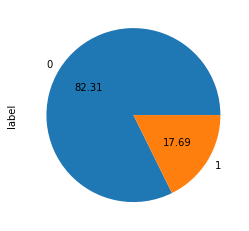

In [26]:
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%0.2f')

Highly Imbalanced Dataset!
Ideas:
- Undersampling: reduce majority class to make it equal to minority class
- Oversampling: increase minority class to make it equal to majority class through resampling
- K-fold cross validation

## Oversampling

In [27]:
!pip install imblearn
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy="not majority")
X_train_2d = X_train.values.reshape(-1, 1) # puts each elem of array in own array
X_res, y_res = ros.fit_resample(X_train_2d, y_train)

0    107
1    107
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

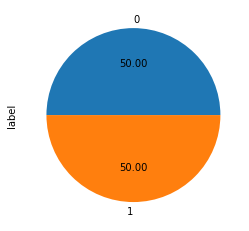

In [28]:
print(y_res.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [29]:
#X_res revert 2_dimensionality
X_res_1d = X_res.flatten()

# classification with resampled vectors
X_res_vect = classification.text2vec(X_res_1d, word_vectors)
X_res_vect_avg = classification.average_vector(X_res_vect)

In [30]:
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Random Forest")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_res_pred)
y_res_pred = classification.classify_predict(X_res_vect_avg, X_test_vect_avg, y_res, "SVM")
classification.print_classification_report(y_test, y_res_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.88      0.88      0.88        50
    begnadet       0.14      0.14      0.14         7

    accuracy                           0.79        57
   macro avg       0.51      0.51      0.51        57
weighted avg       0.79      0.79      0.79        57

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.72      0.88      0.79        41
    begnadet       0.29      0.12      0.17        16

    accuracy                           0.67        57
   macro avg       0.50      0.50      0.48        57
weighted avg       0.60   

## Undersampling

In [31]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0, sampling_strategy="majority")
X_resampled, y_resampled = rus.fit_resample(X_train_2d, y_train)

0    23
1    23
Name: label, dtype: int64


<AxesSubplot: ylabel='label'>

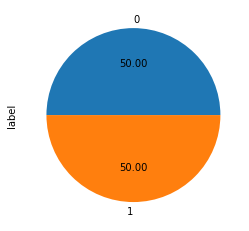

In [32]:
print(y_resampled.value_counts())
y_res.value_counts().plot.pie(autopct='%0.2f')

In [33]:
#X_res revert 2_dimensionality
X_resampled_1d = X_resampled.flatten()

# classification with resampled vectors
X_resampled_vect = classification.text2vec(X_resampled_1d, word_vectors)
X_resampled_vect_avg = classification.average_vector(X_resampled_vect)

In [34]:
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Random Forest")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "Multinomial Naive Bayes")
classification.print_classification_report(y_test, y_resampled_pred)
y_resampled_pred = classification.classify_predict(X_resampled_vect_avg, X_test_vect_avg, y_resampled, "SVM")
classification.print_classification_report(y_test, y_resampled_pred)

############################################################################
Processing Random Forest Classification

              precision    recall  f1-score   support

    verfolgt       0.72      0.88      0.79        41
    begnadet       0.29      0.12      0.17        16

    accuracy                           0.67        57
   macro avg       0.50      0.50      0.48        57
weighted avg       0.60      0.67      0.62        57

classes in y_pred: {0, 1} classes in y_test: {0, 1}
############################################################################
############################################################################
Processing Multinomial Naive Bayes Classification

              precision    recall  f1-score   support

    verfolgt       0.74      0.90      0.81        41
    begnadet       0.43      0.19      0.26        16

    accuracy                           0.70        57
   macro avg       0.58      0.54      0.54        57
weighted avg       0.65   